In [74]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Dataset Imports
from sklearn.datasets import fetch_openml

# Sklearn imports
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.base import clone
from sklearn.base import BaseEstimator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# import the MNIST dataset
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# extract the features and target labels
X, y = mnist['data'], mnist['target']

In [4]:
# We can see that the shape is 70000, 784:
# This corresponds to 70k images with 28 * 28 pixels.
X.shape

(70000, 784)

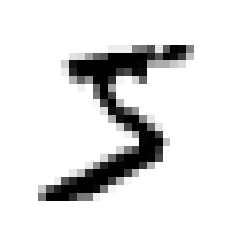

This image is a(n): 5


In [5]:
# To view an image we simply, Reshape the 784 pixel to 28 x 28.
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
print(f'This image is a(n): {y[0]}')

In [6]:
# Note that y is typed as string, so we will cast the list to integers
print(type(y[0]))
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


In [7]:
# Splitting out the training and test data
# No need to programatically split the data, this has already been built to the dataset.
# The first 60k - training, the rest (10k) for testing.
### Note that the dataset is also already shuffled so there is no requirement to complete this action in this case either.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### Training a Binary Classifier
Lets create a classifier that can identify one digit e.g. 5.
This will be a binary (5 or not 5_) detector, capable of distinguishing between 2 classes.

In [8]:
# First we create a set of labels to identify whether the original target label was a 5.
y_train_5 = (y_train == 5) # This will create a list of True/False values where y_train was a 5
y_test_5 = (y_test == 5)

In [9]:
# Now we train a Stochastic Gradient Descent (SGD) classifier.
# Note that SGD relies on some randomness during training, so for reproducibility - set the random_state parameter
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# Lets check how the model predicts.
# Looks good, but how does it perform on a larger scale.
sgd_clf.predict([some_digit])

array([ True])

#### Performance Measures

In [11]:
# Use cross_val_score to perform cross validation on the model
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# Although accuracy of 95% looks impressive, lets try classifying every image as "not 5" and calculate the accuracy.
class Never5Classifier(BaseEstimator):
    def fit(self, X, none):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [16]:
# As we can see, with only, approx, 10% of values = 5, by assuming nothing is 5, you get 90% accuracy.
# This is one of the main reasons that accuracy is generally not a preferred performance measure for classifiers.
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

#### Confusion Matrix
A much better performance measure for classifiers.

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [22]:
cm = confusion_matrix(y_train_pred, y_train_5)
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]

Using a confusion matrix, it is possible to create more concise metrics.

In [24]:
# Precision 
# True positives vs all predicted positives - When you predicted positive, how many were correct?
TP / (TP + FP)

0.8370879772350012

In [30]:
# sklearn builtin function
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
# Recall / Sensitivity / True positive rate
# True positives vs all actual positives - How well did you predict the actual positives?
TP / (TP + FN)

0.6511713705958311

In [32]:
# sklearn builtin function
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [35]:
# F1 Score - Harmonic mean of precision + recall
# TP / (TP + ((FN + FP) / 2) )
TP / (TP + ((FN + FP) / 2) )

0.7325171197343847

In [36]:
# sklearn builtin function
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision / Recall Tradeoff

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

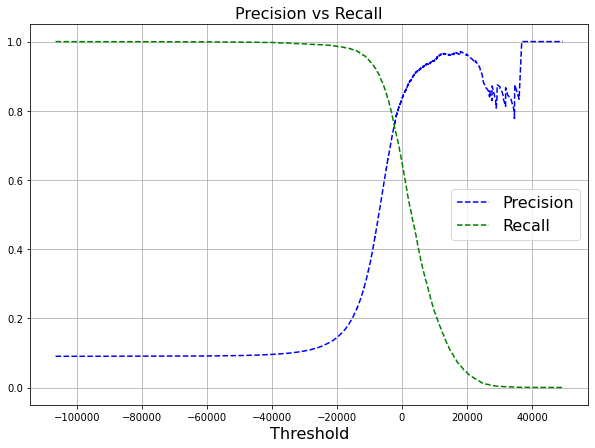

In [58]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (10, 7))
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label = "Recall")
    plt.legend(loc = "right", fontsize = 16)
    plt.grid()
    plt.xlabel("Threshold", fontsize = 16)
    plt.title("Precision vs Recall", fontsize = 16)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

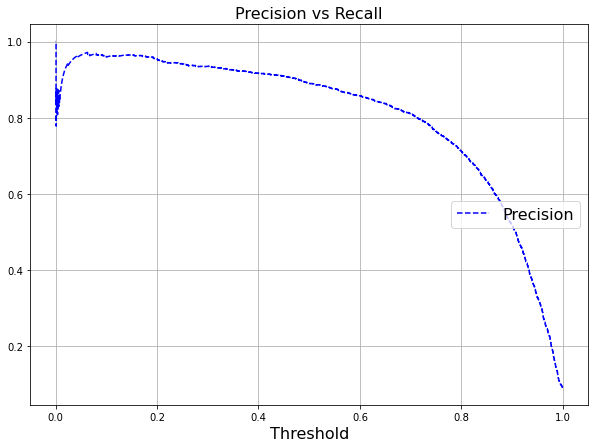

In [61]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize = (10, 7))
    plt.plot(recalls, precisions, "b--", label = "Precision")
    plt.grid()
    plt.xlabel("Threshold", fontsize = 16)
    plt.title("Precision vs Recall", fontsize = 16)
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [66]:
# Lets say we want to aim for around 90% Precision
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]
threshold_90_precision

3370.0194991439557

In [67]:
# We can check the precisions using the threshold for 90% precision
# Now we have a classifier with a precision of 90% - but a high precision classifier is not very useful with low recall.
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


#### The ROC Curve

In [71]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

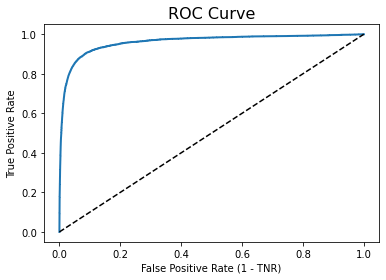

In [73]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve", fontsize = 16)
    plt.xlabel("False Positive Rate (1 - TNR)")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [75]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616